In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

train_dir = '../data/chest_xray/train'
test_dir = '../data/chest_xray/test'
val_dir = '../data/chest_xray/val'

img_height = 256
img_width = 256

In [2]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/chest_xray/train', 
    labels='inferred',
    validation_split = 0.2,
    subset="training",
    seed=14)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/chest_xray/train', 
    labels='inferred',
    validation_split = 0.2,
    subset="validation",
    seed=14)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/chest_xray/test', 
    labels='inferred',
    shuffle = False)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


<ipython-input-5-259e5708b6cd>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)
<ipython-input-5-259e5708b6cd>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig1.savefig('../secret/img1.png', dpi=100, bbox='tight')


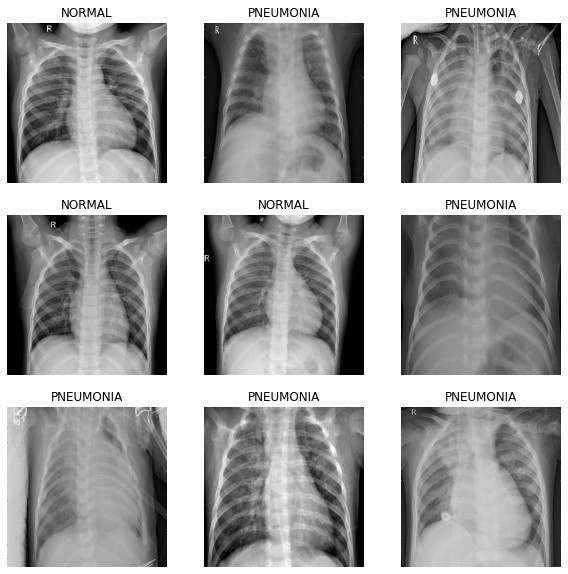

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(4):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
        plt.axis("off")

fig1 = plt.gcf()
fig1.savefig('../secret/img1.png', dpi=100, bbox='tight')

In [7]:
plt.show()
plt.savefig('../secret/img1.png')

<Figure size 432x288 with 0 Axes>

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [5]:
aug_ds = train_data.map( lambda x, y: (data_augmentation(x, training=True), y))
augmented_training_data = train_data.concatenate(aug_ds)

In [6]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [7]:
augmented_training_data = augmented_training_data.shuffle(1000)
augmented_training_data = augmented_training_data.map(preprocess).prefetch(1)
val_data = val_data.map(preprocess).prefetch(1)
test_data = test_data.map(preprocess).prefetch(1)

In [8]:
base_model = InceptionV3(weights = 'imagenet', include_top = False)

for layer in base_model.layers:
    layer.trainable = False

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(avg)
model = tf.keras.Model(inputs = base_model.input, outputs = output)

In [9]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['acc', tf.keras.metrics.Recall()])

In [10]:
history = model.fit(
    augmented_training_data, 
    epochs=6, 
    validation_data=val_data, 
    class_weight = {0:2.88, 1:1})

Epoch 1/6
262/262 [==============================] - 96s 367ms/step - loss: 0.4894 - acc: 0.8506 - recall: 0.8467 - val_loss: 0.1944 - val_acc: 0.9338 - val_recall: 0.9527
Epoch 2/6
262/262 [==============================] - 94s 357ms/step - loss: 0.3220 - acc: 0.9142 - recall: 0.9086 - val_loss: 0.2585 - val_acc: 0.8840 - val_recall: 0.8519
Epoch 3/6
262/262 [==============================] - 93s 354ms/step - loss: 0.2868 - acc: 0.9208 - recall: 0.9166 - val_loss: 0.2180 - val_acc: 0.9099 - val_recall: 0.8889
Epoch 4/6
262/262 [==============================] - 95s 361ms/step - loss: 0.2589 - acc: 0.9299 - recall: 0.9243 - val_loss: 0.1776 - val_acc: 0.9300 - val_recall: 0.9208
Epoch 5/6
262/262 [==============================] - 93s 357ms/step - loss: 0.2540 - acc: 0.9310 - recall: 0.9264 - val_loss: 0.1778 - val_acc: 0.9310 - val_recall: 0.9246
Epoch 6/6
262/262 [==============================] - 95s 362ms/step - loss: 0.2408 - acc: 0.9367 - recall: 0.9327 - val_loss: 0.1475 - val_a

In [11]:
model.evaluate(test_data)

20/20 [==============================] - 7s 332ms/step - loss: 0.3956 - acc: 0.8478 - recall: 0.9641


[0.39561352133750916, 0.8477563858032227, 0.964102566242218]

In [13]:
for images, labels in train_data.take(1):
    print(labels[0])
    break

tf.Tensor(1, shape=(), dtype=int32)


In [14]:
train_data.class_names

['NORMAL', 'PNEUMONIA']

In [15]:
history2 = model.fit(
    augmented_training_data, 
    epochs=8, 
    validation_data=val_data)

Epoch 1/8
262/262 [==============================] - 93s 355ms/step - loss: 0.1353 - acc: 0.9490 - recall: 0.9677 - val_loss: 0.1269 - val_acc: 0.9521 - val_recall: 0.9796
Epoch 2/8
262/262 [==============================] - 95s 361ms/step - loss: 0.1325 - acc: 0.9494 - recall: 0.9691 - val_loss: 0.1334 - val_acc: 0.9463 - val_recall: 0.9476
Epoch 3/8
262/262 [==============================] - 94s 357ms/step - loss: 0.1276 - acc: 0.9515 - recall: 0.9691 - val_loss: 0.1264 - val_acc: 0.9473 - val_recall: 0.9527
Epoch 4/8
262/262 [==============================] - 94s 357ms/step - loss: 0.1228 - acc: 0.9543 - recall: 0.9702 - val_loss: 0.1214 - val_acc: 0.9521 - val_recall: 0.9834
Epoch 5/8
262/262 [==============================] - 94s 357ms/step - loss: 0.1212 - acc: 0.9527 - recall: 0.9709 - val_loss: 0.1264 - val_acc: 0.9492 - val_recall: 0.9860
Epoch 6/8
262/262 [==============================] - 94s 358ms/step - loss: 0.1204 - acc: 0.9543 - recall: 0.9696 - val_loss: 0.1329 - val_a

In [16]:
model.evaluate(test_data)

20/20 [==============================] - 6s 316ms/step - loss: 0.5435 - acc: 0.7965 - recall: 0.9769


[0.5435202717781067, 0.7964743375778198, 0.9769230484962463]

In [17]:
model.save('../models/inceptionv3v1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/inceptionv3v1\assets


In [20]:
reconstructed_model = tf.keras.models.load_model('../models/inceptionv3v1')

In [21]:
reconstructed_model.evaluate(test_data) # same stats as before

20/20 [==============================] - 6s 308ms/step - loss: 0.5435 - acc: 0.7965 - recall: 0.9769


[0.5435202717781067, 0.7964743375778198, 0.9769230484962463]

## Try ReLU

-- really bad

In [8]:
base_model = InceptionV3(weights = 'imagenet', include_top = False)

for layer in base_model.layers:
    layer.trainable = False

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation = 'relu')(avg)
relu_model = tf.keras.Model(inputs = base_model.input, outputs = output)

relu_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['acc', tf.keras.metrics.Recall()])

In [9]:
relu_history = relu_model.fit(
    augmented_training_data, 
    epochs=10, 
    validation_data=val_data)

Epoch 1/10
 89/262 [=========>....................] - ETA: 53s - loss: 11.3302 - acc: 0.2655 - recall: 0.0000e+00

KeyboardInterrupt: 